In [27]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

df = pd.read_csv('C:/Users/Csaba/Downloads/pol_events_predicted.csv')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510021 entries, 0 to 510020
Data columns (total 95 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id                                510021 non-null  int64  
 1   matchId                           510021 non-null  int64  
 2   matchPeriod                       510021 non-null  object 
 3   minute                            510021 non-null  int64  
 4   second                            510021 non-null  int64  
 5   relatedEventId                    496718 non-null  float64
 6   SeasonID                          510021 non-null  int64  
 7   SeasonName                        510021 non-null  object 
 8   MatchName                         510021 non-null  object 
 9   MatchDateUTC                      510021 non-null  object 
 10  location_x                        510021 non-null  float64
 11  location_y                        510021 non-null  f

In [29]:
nanseries = df.isnull().sum() / df.shape[0] * 100
nullnanseries = nanseries[nanseries > 0]
print(nanseries[nanseries > 0])
len(nullnanseries)

relatedEventId                 2.608324
pass_accurate                 30.863239
pass_angle                    30.863239
pass_height                   39.152309
pass_length                   30.863239
                                ...    
possession_attack_withGoal    47.338443
possession_attack_flank       47.338443
possession_attack_xg          47.338443
pass_carry_endLocation_x      21.866158
pass_carry_endLocation_y      21.866158
Length: 61, dtype: float64


61

<Axes: >

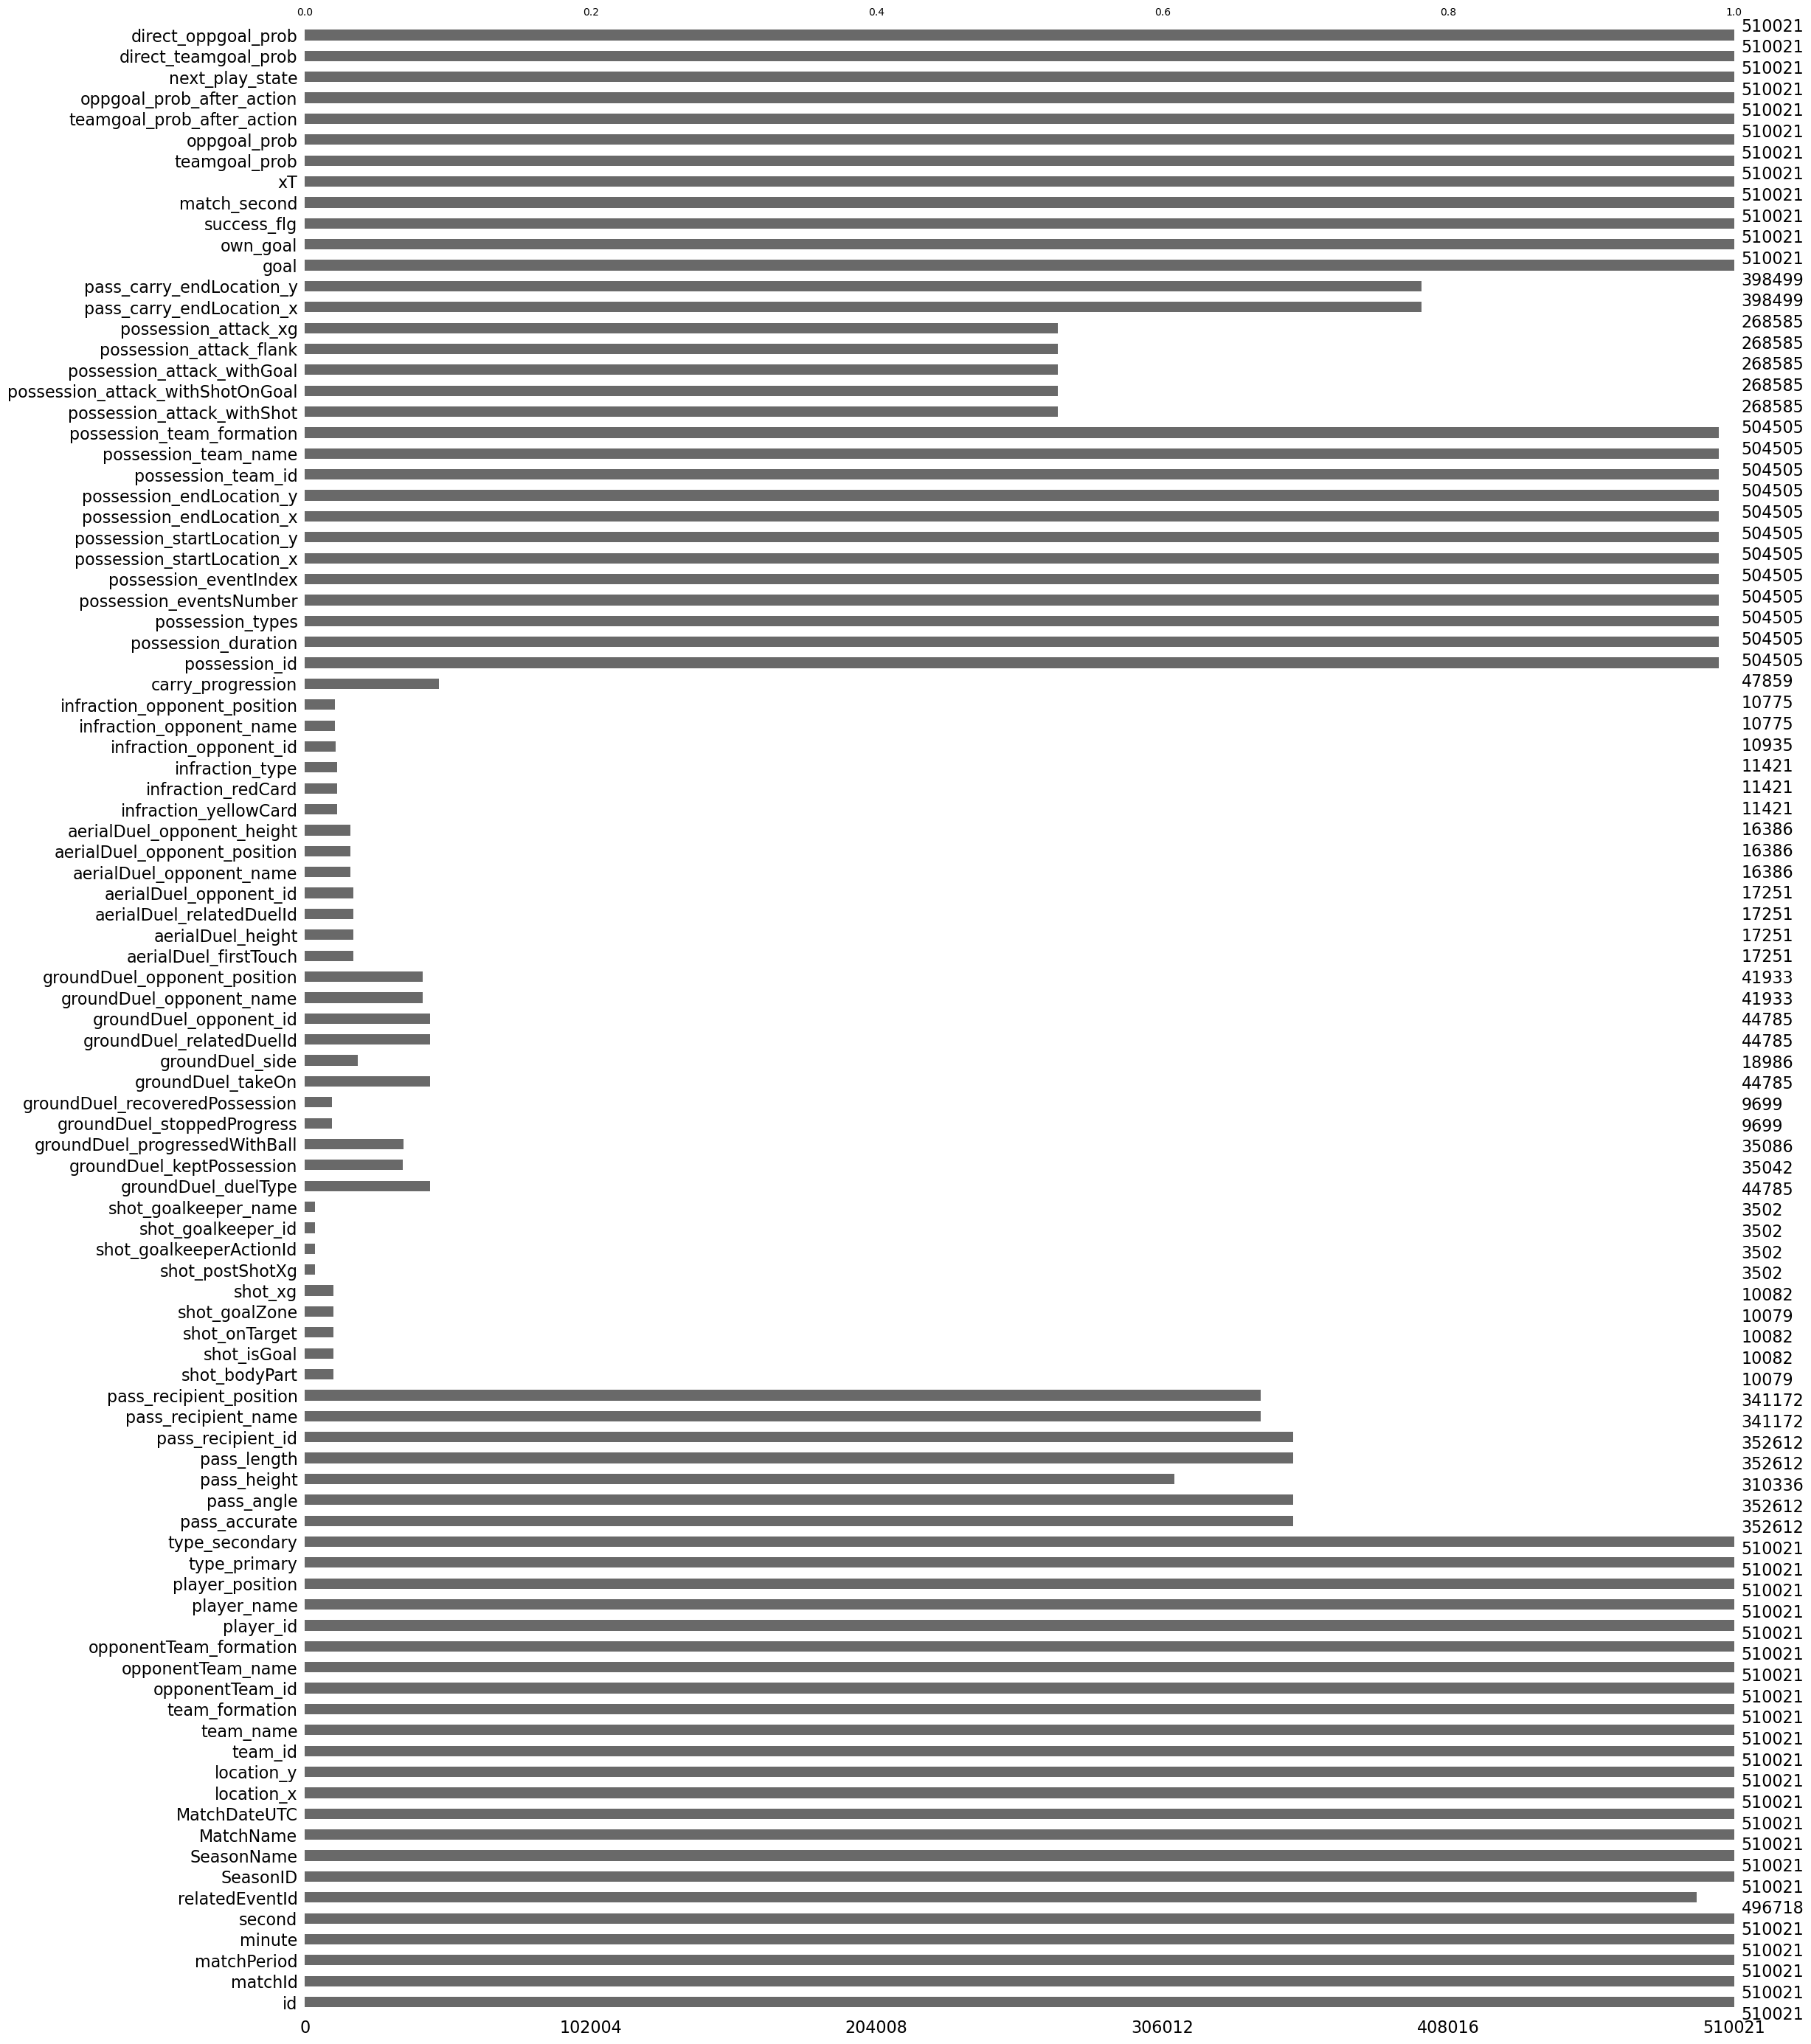

In [30]:
import missingno as msno

msno.bar(df)

In [31]:
df.type_primary.unique()

array(['pass', 'touch', 'clearance', 'throw_in', 'duel', 'interception',
       'infraction', 'free_kick', 'corner', 'shot', 'goal_kick',
       'acceleration', 'fairplay', 'own_goal', 'penalty'], dtype=object)

In [32]:
df.type_secondary.unique()

array(["['back_pass', 'short_or_medium_pass']",
       "['lateral_pass', 'short_or_medium_pass']", "['carry']", ...,
       "['deep_completion', 'lateral_pass', 'pass_to_penalty_area', 'third_assist', 'short_or_medium_pass']",
       "['lateral_pass', 'long_pass', 'pass_to_final_third', 'pass_to_penalty_area', 'shot_assist']",
       "['forward_pass', 'long_pass', 'pass_to_final_third', 'pass_to_penalty_area', 'carry', 'smart_pass', 'under_pressure']"],
      dtype=object)

-0.83498892
0.98548661


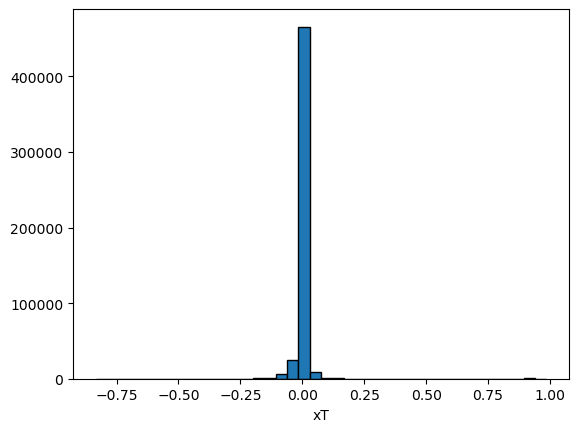

In [33]:
print(df['xT'].min())
print(df['xT'].max())
plt.hist(df['xT'], bins=40, edgecolor='black')
plt.xlabel('xT')
plt.show()

In [34]:
def preprocessing(df):
    df.drop(labels=['id', 'matchId', 'relatedEventId', 'SeasonID',
       'SeasonName', 'groundDuel_duelType',
       'groundDuel_keptPossession', 'groundDuel_progressedWithBall',
       'groundDuel_stoppedProgress', 'groundDuel_recoveredPossession',
       'groundDuel_takeOn', 'groundDuel_side', 'groundDuel_relatedDuelId',
       'groundDuel_opponent_id', 'groundDuel_opponent_name',
       'groundDuel_opponent_position', 'aerialDuel_firstTouch',
       'aerialDuel_height', 'aerialDuel_relatedDuelId',
       'aerialDuel_opponent_id', 'aerialDuel_opponent_name',
       'aerialDuel_opponent_position', 'aerialDuel_opponent_height',
       'infraction_yellowCard', 'infraction_redCard', 'infraction_type',
       'infraction_opponent_id', 'infraction_opponent_name',
       'infraction_opponent_position', 'shot_bodyPart', 'shot_goalkeeperActionId',
       'shot_goalkeeper_id', 'shot_goalkeeper_name', 'shot_goalZone', 'possession_attack_flank', 'team_id', 'opponentTeam_id', 'player_id', 'pass_recipient_id', 'possession_id', 'possession_team_id', 'matchPeriod', 'minute', 'second', 'MatchDateUTC', 'team_name', 'team_formation',
       'opponentTeam_name', 'opponentTeam_formation','player_position', 'MatchName', 'pass_recipient_name', 'pass_recipient_position', 'player_name', 'pass_recipient_name', 'pass_recipient_position', 'possession_team_name', 'possession_team_formation', 'next_play_state', 'match_second', 'own_goal'], axis=1, inplace=True)
    df.drop(labels=['possession_duration',
       'possession_eventsNumber', 'possession_eventIndex',
       'possession_startLocation_x', 'possession_startLocation_y',
       'possession_endLocation_x', 'possession_endLocation_y',
       'possession_attack_withShot', 'possession_attack_withShotOnGoal',
       'possession_attack_withGoal',
       'pass_carry_endLocation_x', 'pass_carry_endLocation_y', 'goal', 'shot_isGoal', 'shot_onTarget', 'shot_xg', 'shot_postShotXg', 'carry_progression' ], axis=1, inplace=True)
    #kiveszünk minden prob-ot, mert lehet, hogy az xT-ből van származtatva, valamint van, ahol 0,8 a korreláció, ami nagyon megkönnyíti a modellépítést
    df.drop(labels=['direct_oppgoal_prob', 'oppgoal_prob', 'teamgoal_prob', 'direct_teamgoal_prob', 'teamgoal_prob_after_action',  'oppgoal_prob_after_action'], axis=1, inplace=True)
    df.possession_attack_xg.replace(np.nan, 0, inplace=True)
    df['next_location_x'] = df['location_x'].shift(periods=-1, fill_value=0)
    df['next_location_y'] = df['location_y'].shift(periods=-1, fill_value=0)
    df['dist_from_goal'] = [math.sqrt(np.square(105 - df.iloc[x]['location_x']) + np.square(34 - df.iloc[x]['location_y'])) for x in range(len(df.location_x))]
    df['next_dist_from_goal'] = [math.sqrt(np.square(105 - df.iloc[x]['next_location_x']) + np.square(34 - df.iloc[x]['next_location_y'])) for x in range(len(df.next_location_x))]
    df.dropna(inplace=True)
    df = pd.get_dummies(df, columns=['pass_height']) #kapunk: pass_height_blocked/high/low oszlopokat
    index = df[df['type_primary']!='pass'].index
    df.drop(index, inplace=True)
    return df

In [35]:
df = preprocessing(df)
#xT alapból az action xT-je, nem az x,y location-é, mert lehet negatív is

# Eredeti: Elől lévő 60%, közelebb visz 25%-al

In [36]:
def basic_filter():    
    resultsdf1 = None
    for i in range(0,7):
        progress = 0.25 + 0.10 * i
        for j in range(0, 6):        
            front = j * 15
            df['through_pass'] = np.where(((df['next_dist_from_goal'] / df['dist_from_goal'] < progress) & (df['location_x'] > front)), True, False)
            new_row = {'Elől lévő %-os részarány': [(100-front/105 * 100)], '%-os közelítés': [(100-progress*100)], 'Kiugratások száma': [df.through_pass.sum()], 'front':[front], 'progress': [progress]}
            new_row_df = pd.DataFrame(data=new_row)
            if resultsdf1 is None:
                resultsdf1 = new_row_df
            else:            
                resultsdf1 = pd.concat([resultsdf1, new_row_df], ignore_index = True)
    resultsdf1['Kiugratások aránya'] = resultsdf1['Kiugratások száma'] / df.shape[0] * 100
    return resultsdf1

# Elől lévő 60%, közelebb visz 25%-al + through pass a type_secondary

In [37]:
def filter_with_label():    
    resultsdf2 = None
    for i in range(0,7):
        progress = 0.25 + 0.10 * i
        for j in range(0, 6):        
            front = j * 15        
            df['through_pass'] = np.where(((df['next_dist_from_goal'] / df['dist_from_goal'] < progress) & (df['location_x'] > front) & (df['type_secondary'].str.contains('through_pass'))), True, False)
            new_row = {'Elől lévő %-os részarány': [(100-front/105 * 100)], '%-os közelítés': [(100-progress*100)], 'Kiugratások száma': [df.through_pass.sum()], 'front':[front], 'progress': [progress]}
            new_row_df = pd.DataFrame(data=new_row)
            if resultsdf2 is None:
                resultsdf2 = new_row_df
            else:            
                resultsdf2 = pd.concat([resultsdf2, new_row_df], ignore_index = True)
    resultsdf2['Kiugratások aránya'] = resultsdf2['Kiugratások száma'] / df.shape[0] * 100
    return resultsdf2

# Elől lévő 60%, közelebb visz 25%-al + xT változás legmagasabb 0,5%

In [38]:
def filter_with_xT():   
    resultsdf3 = None
    for i in range(0,7):
        progress = 0.25 + 0.10 * i
        for j in range(0, 6):        
            front = j * 15
            for k in range(1,7):
                p = 0.01 * k
                num = round(df.shape[0] * p)
                treshold = df.nlargest(num, 'xT')['xT'].min()
                df['through_pass'] = np.where(((df['next_dist_from_goal'] / df['dist_from_goal'] < progress) & (df['location_x'] > front) & (df['xT'] > treshold)), True, False)
                new_row = {'Elől lévő %-os részarány': [(100-front/105 * 100)], '%-os közelítés': [(100-progress*100)], 'Kiugratások száma': [df.through_pass.sum()], 'Legmagasabb x%-nyi xT változás': [p*100], 'front':[front], 'progress': [progress], 'p': [p]}
                new_row_df = pd.DataFrame(data=new_row)
                if resultsdf3 is None:
                    resultsdf3 = new_row_df
                else:            
                    resultsdf3 = pd.concat([resultsdf3, new_row_df], ignore_index = True)
    resultsdf3['Kiugratások aránya'] = resultsdf3['Kiugratások száma'] / df.shape[0] * 100
    return resultsdf3

# Through_pass label jellemzők

In [39]:
def through_pass_by_label():
    df['through_pass'] = np.where(df['type_secondary'].str.contains('through_pass'), True, False)
    print('Kiugratás: ' + str(df.through_pass.sum()) + ', Összes passz: ' + str(df.shape[0]) + ', arányuk: ' + str(df.through_pass.sum()/df.shape[0]))

In [40]:
import mplsoccer
import matplotlib.pyplot as plt
def plot_passes():
    
    df_basicfilter = df[df['through_pass']==True]

    #xT változás plotolva
    plt.hist(df_basicfilter['xT'], bins=40, edgecolor='black')
    plt.xlabel('xT')
    plt.show()

    #passzok plotolva
    df_to_plot = df_basicfilter[0:100]
    pitch = mplsoccer.Pitch(pitch_type='wyscout') #100,100-as pálya, százalékban
    fig,ax=pitch.draw()
    fig.suptitle('néhány kiválasztott kiugratás')
    pitch.arrows(df_to_plot.location_x/105*100, df_to_plot.location_y/68*100, df_to_plot.next_location_x/105*100, df_to_plot.next_location_y/68*100, ax=ax)

    #pass kiindulás heatmap
    pitch = mplsoccer.Pitch(pitch_type='wyscout', line_zorder=2, line_color='black')
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0, endnote_space=0)
    bin_statistic = pitch.bin_statistic(df_basicfilter.location_x/105*100, df_basicfilter.location_y/68*100, statistic='count', bins=(6, 5), normalize=False)
    pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
    cbar = plt.colorbar(pcm)
    fig.suptitle('passz kiindulás heatmap')
    plt.show()
    
    #pass végpont heatmap
    pitch = mplsoccer.Pitch(pitch_type='wyscout', line_zorder=2, line_color='black')
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0, endnote_space=0)
    bin_statistic = pitch.bin_statistic(df_basicfilter.next_location_x/105*100, df_basicfilter.next_location_y/68*100, statistic='count', bins=(6, 5), normalize=False)
    pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
    cbar = plt.colorbar(pcm)
    fig.suptitle('passz végpont heatmap')
    plt.show()

Kiugratás: 5923, Összes passz: 304623, arányuk: 0.019443705826546257


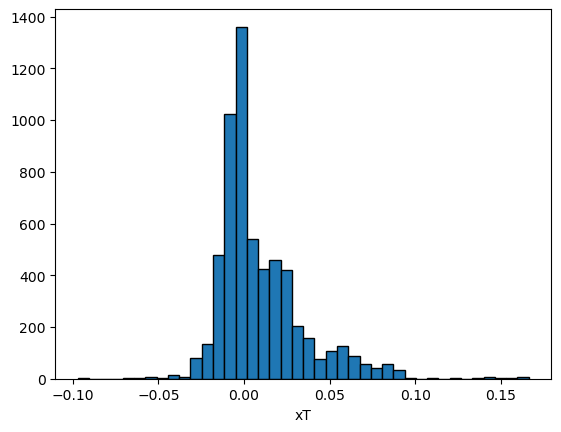

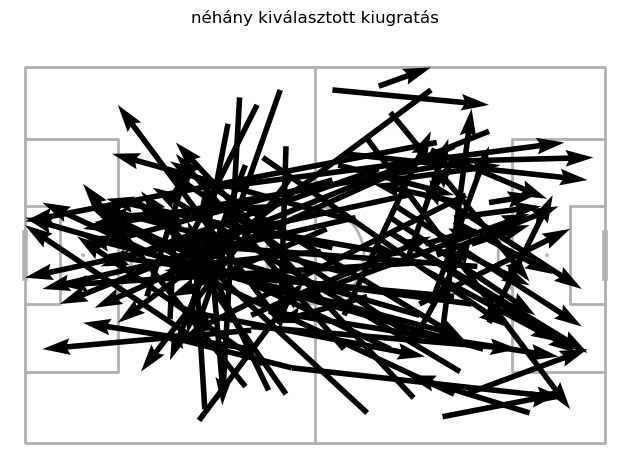

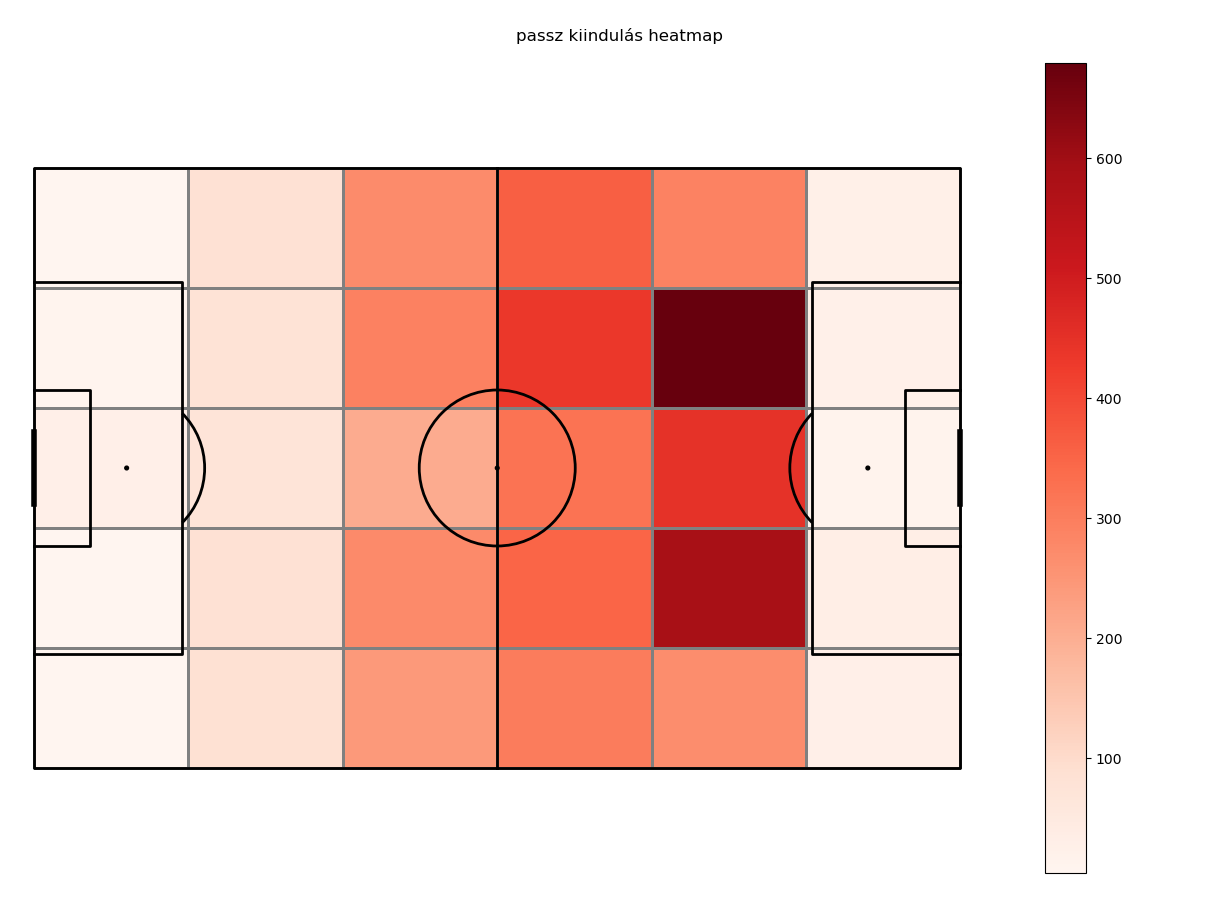

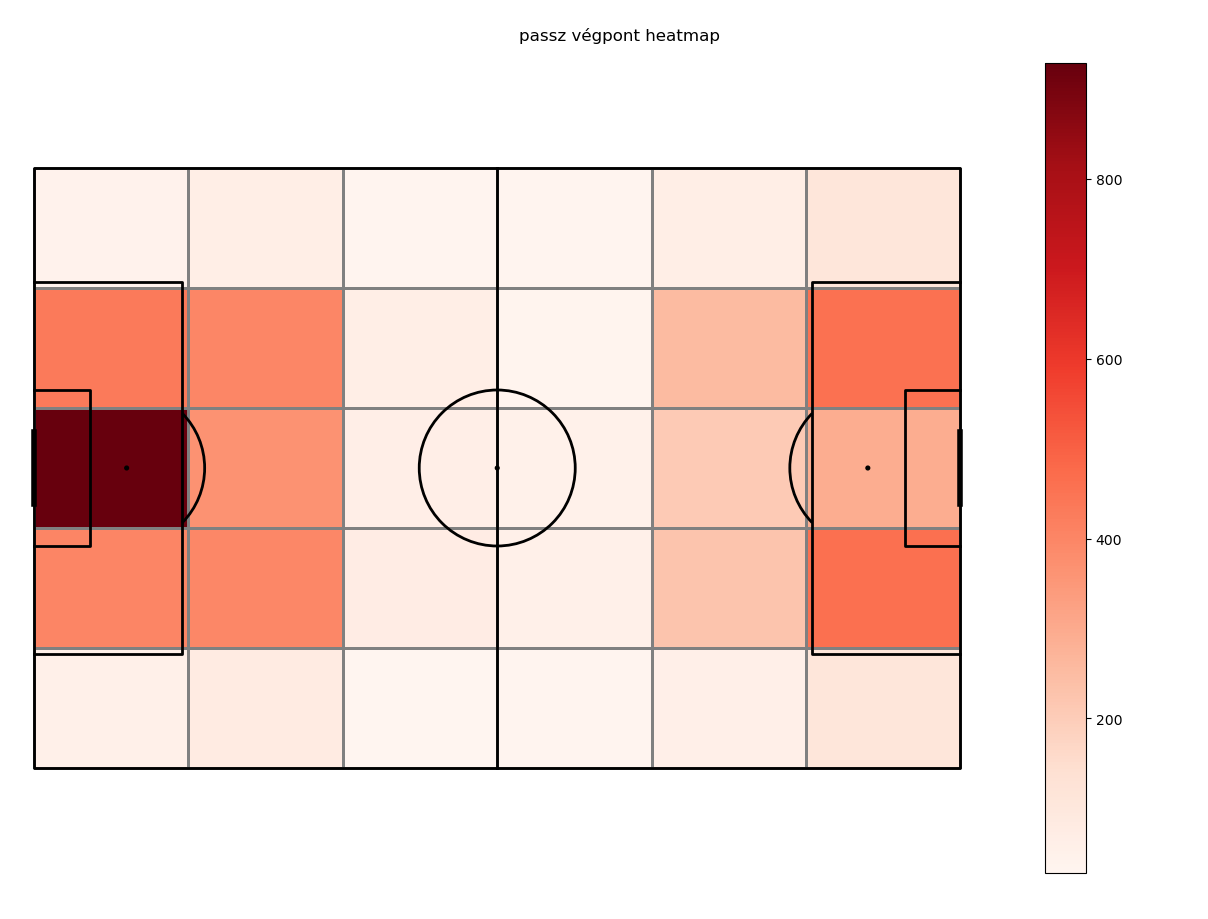

In [41]:
through_pass_by_label()
plot_passes()

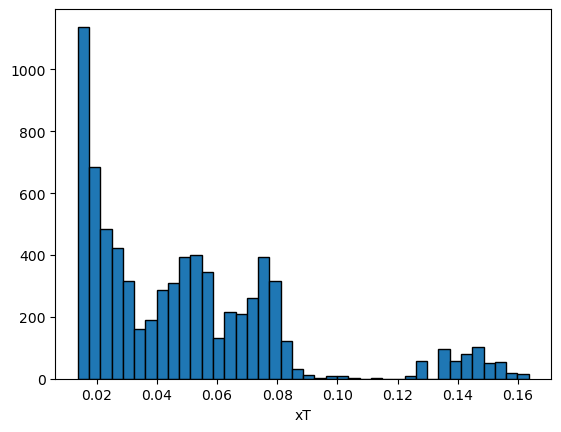

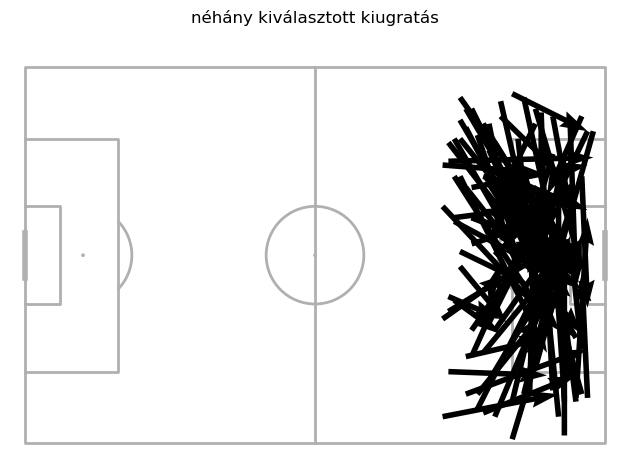

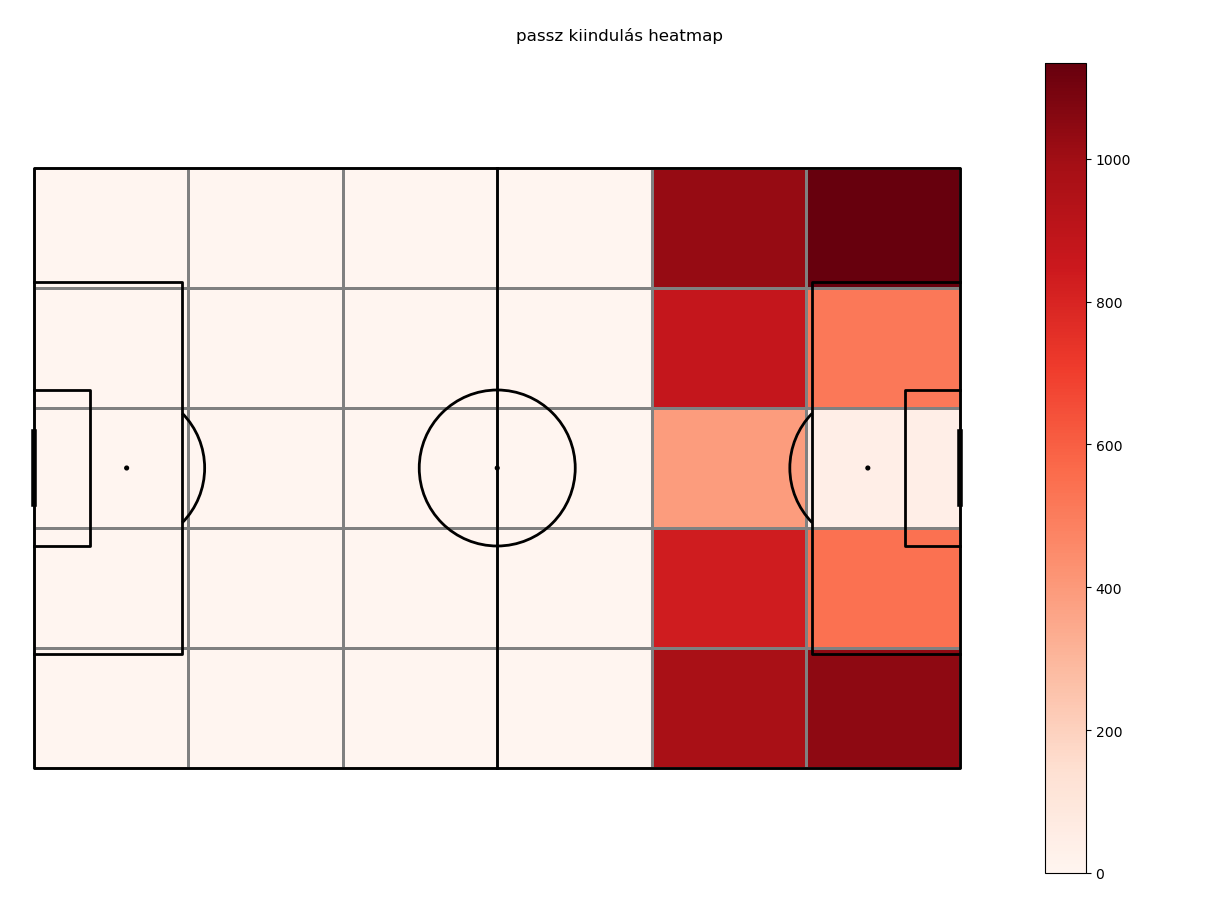

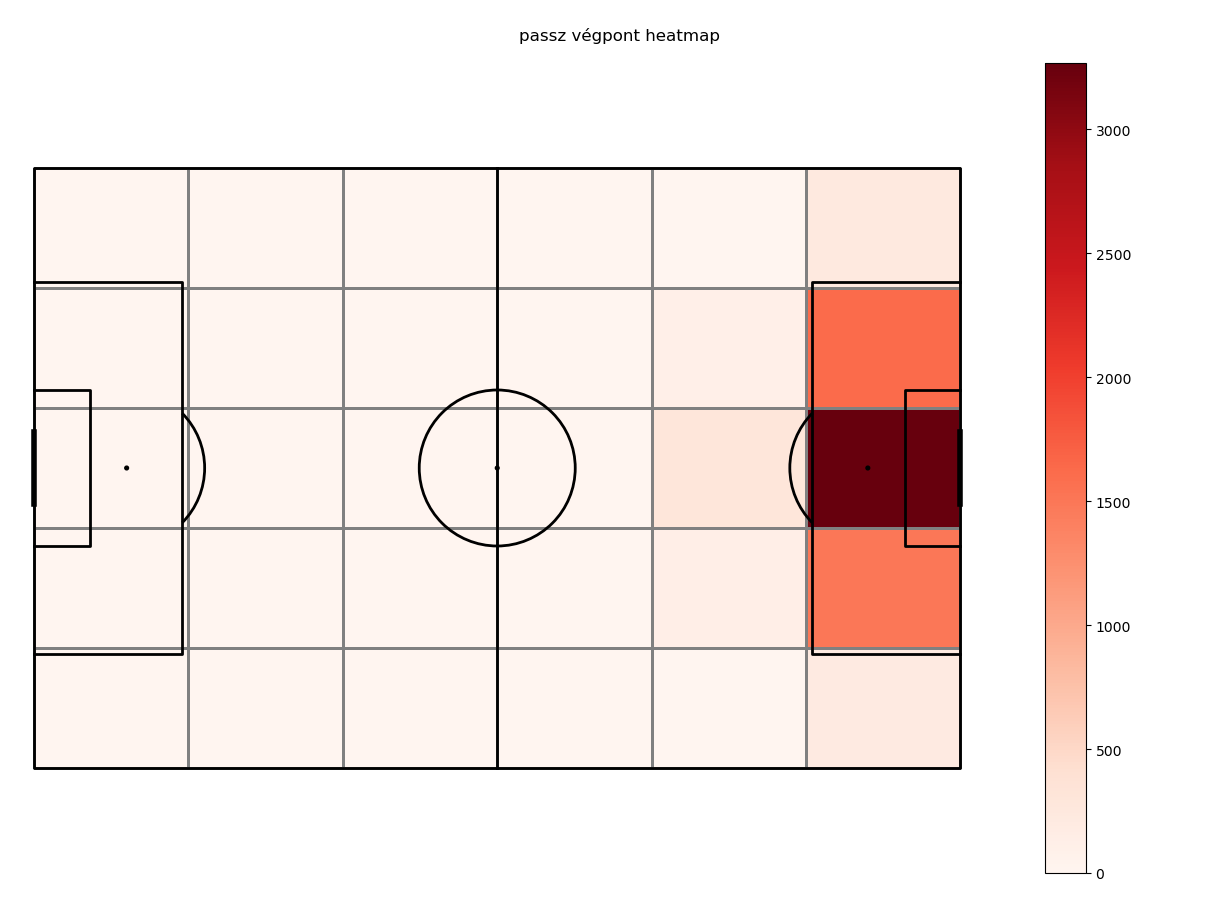

In [42]:
xTdf = filter_with_xT()
plot_passes()

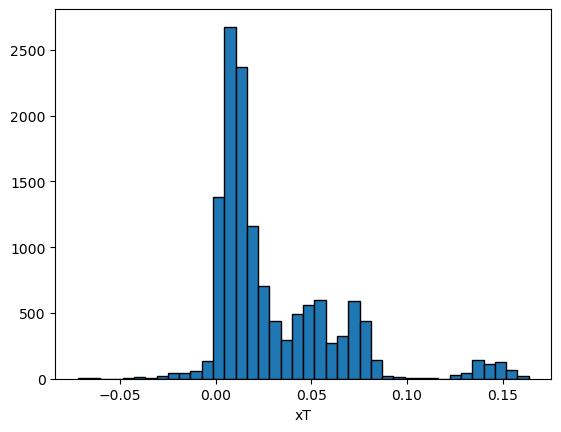

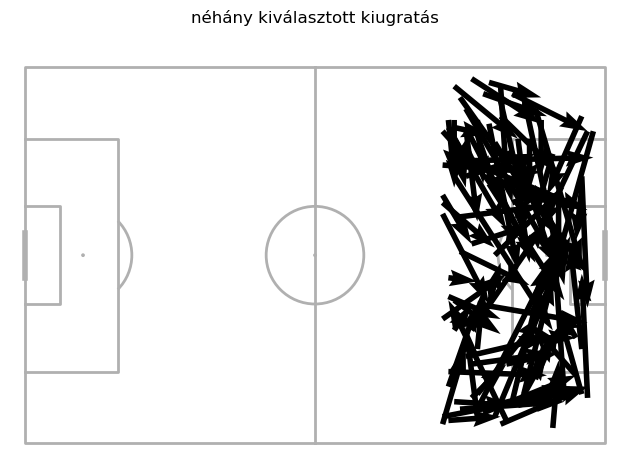

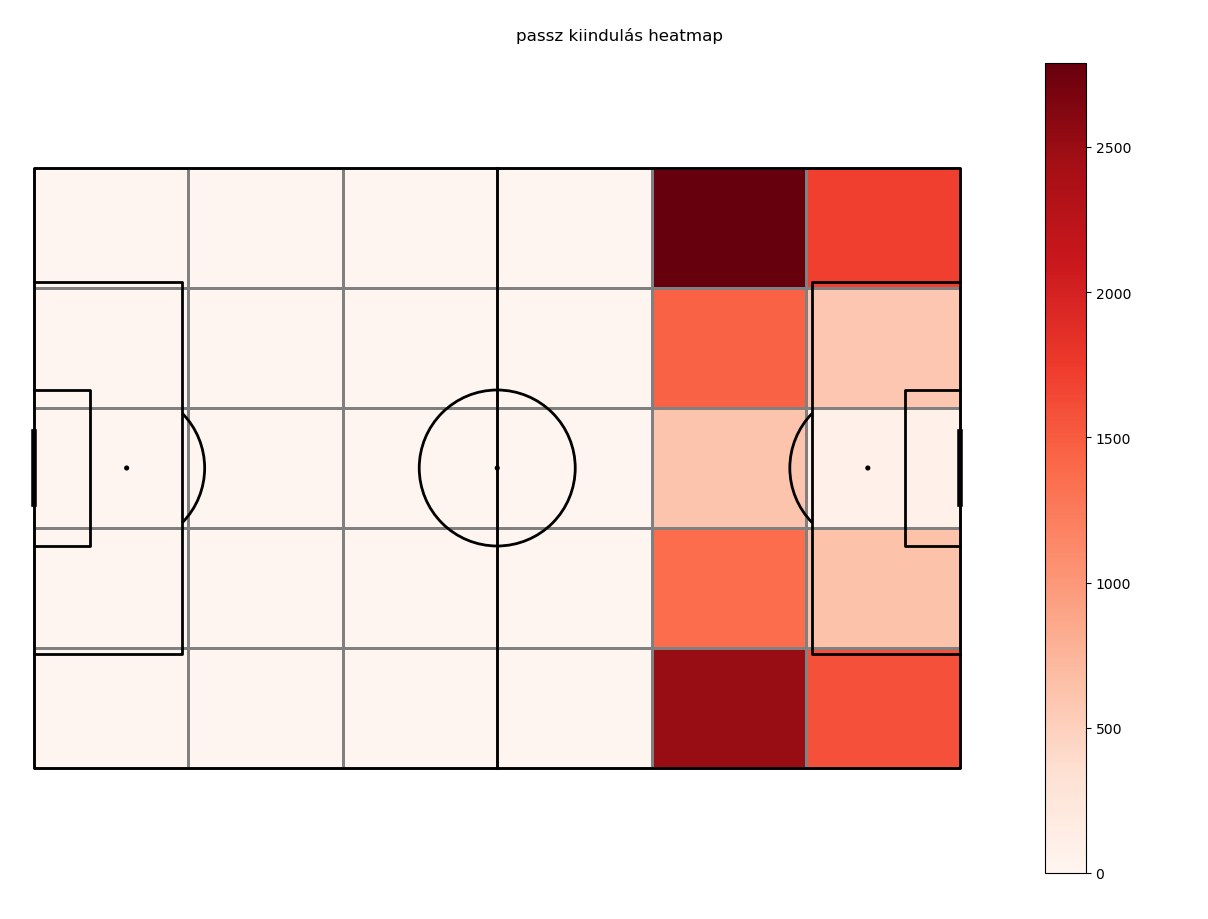

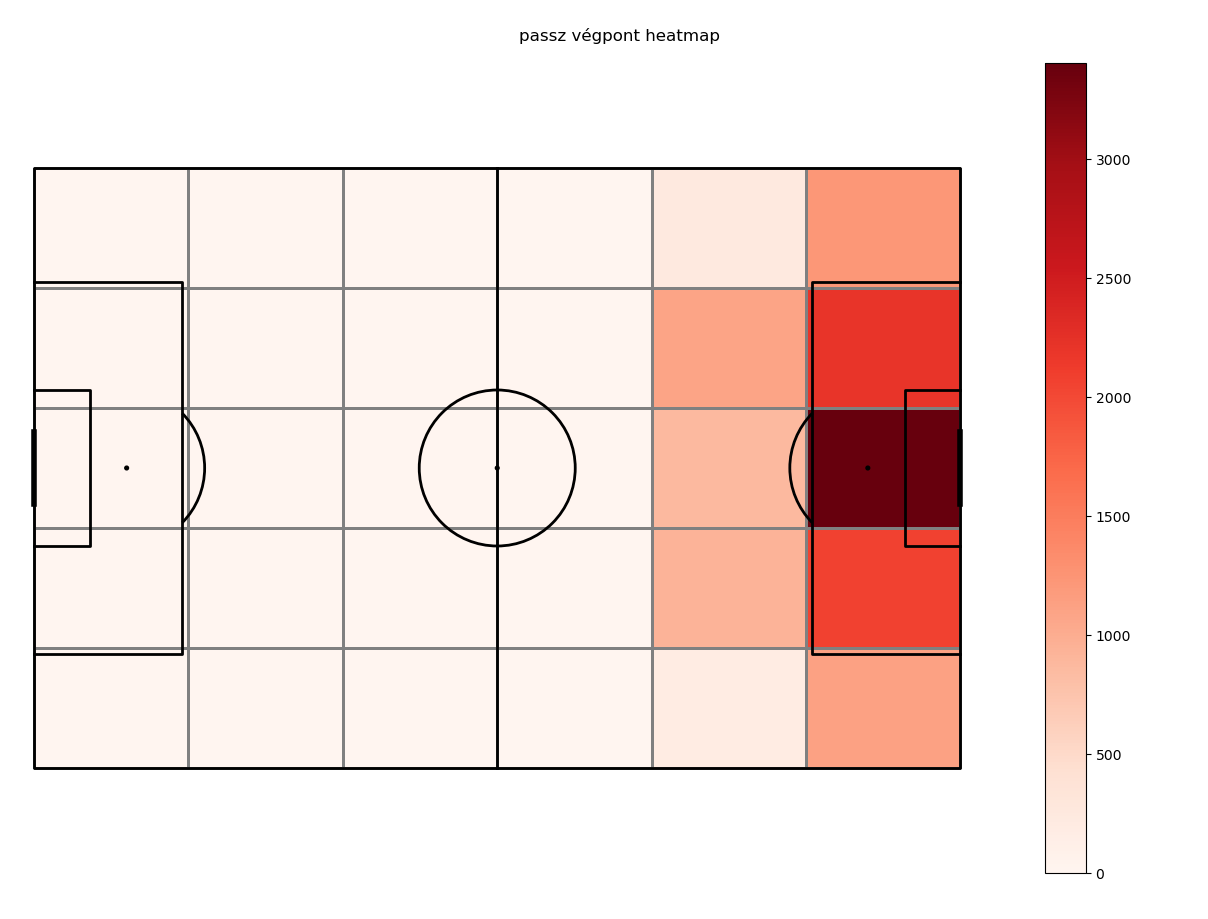

In [43]:
basicdf = basic_filter()
plot_passes()

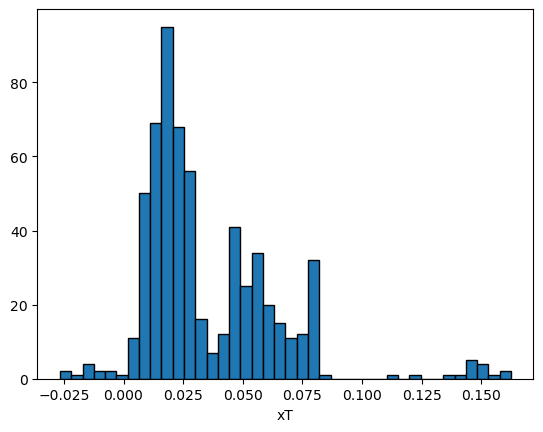

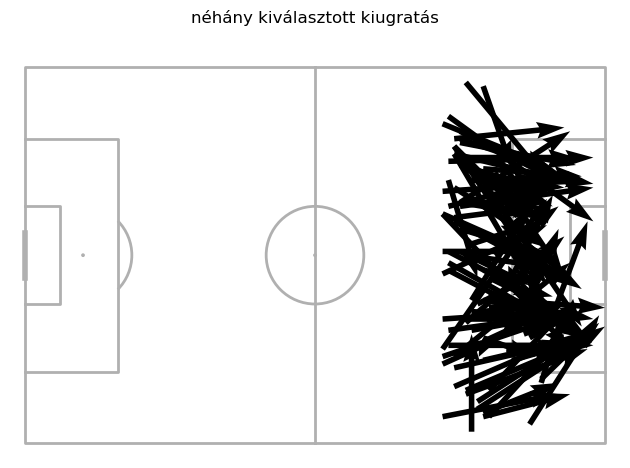

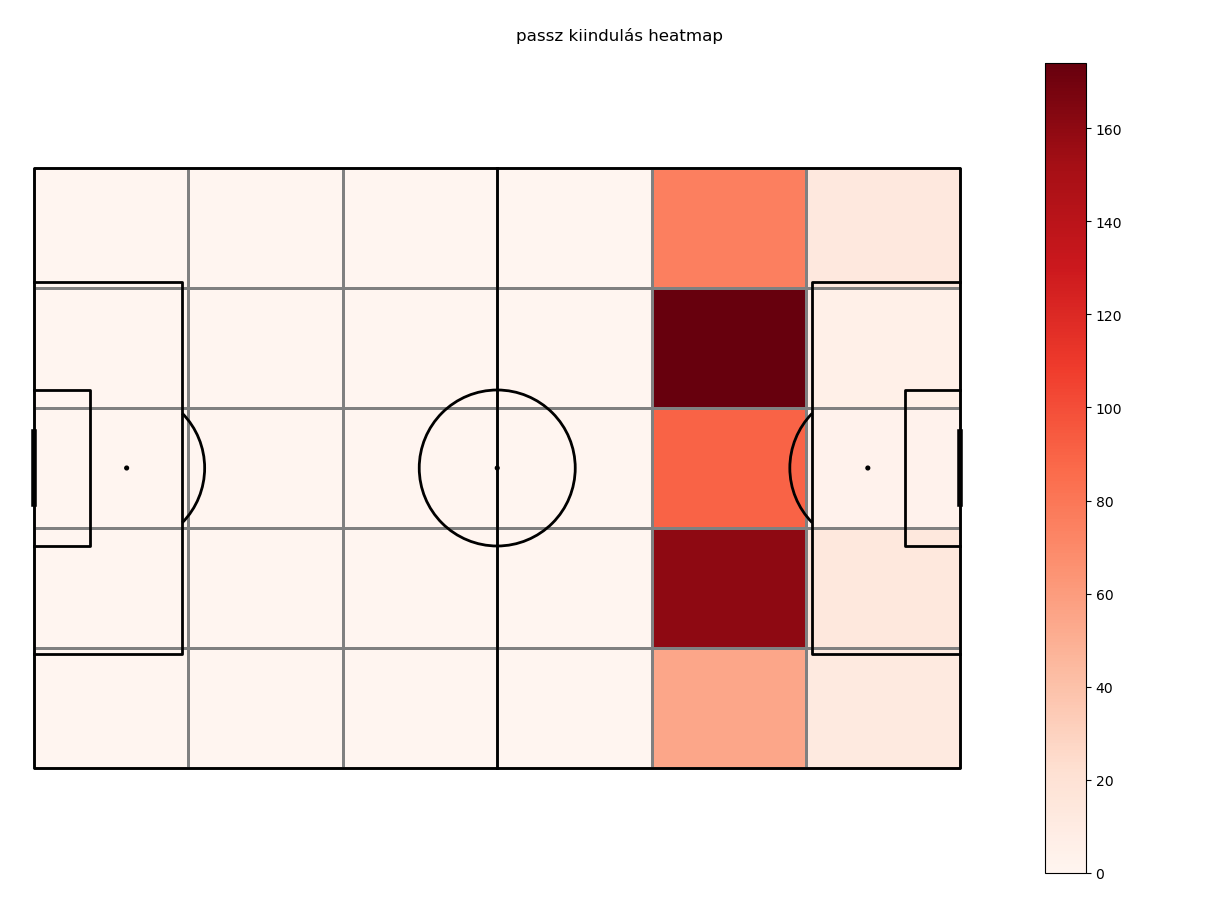

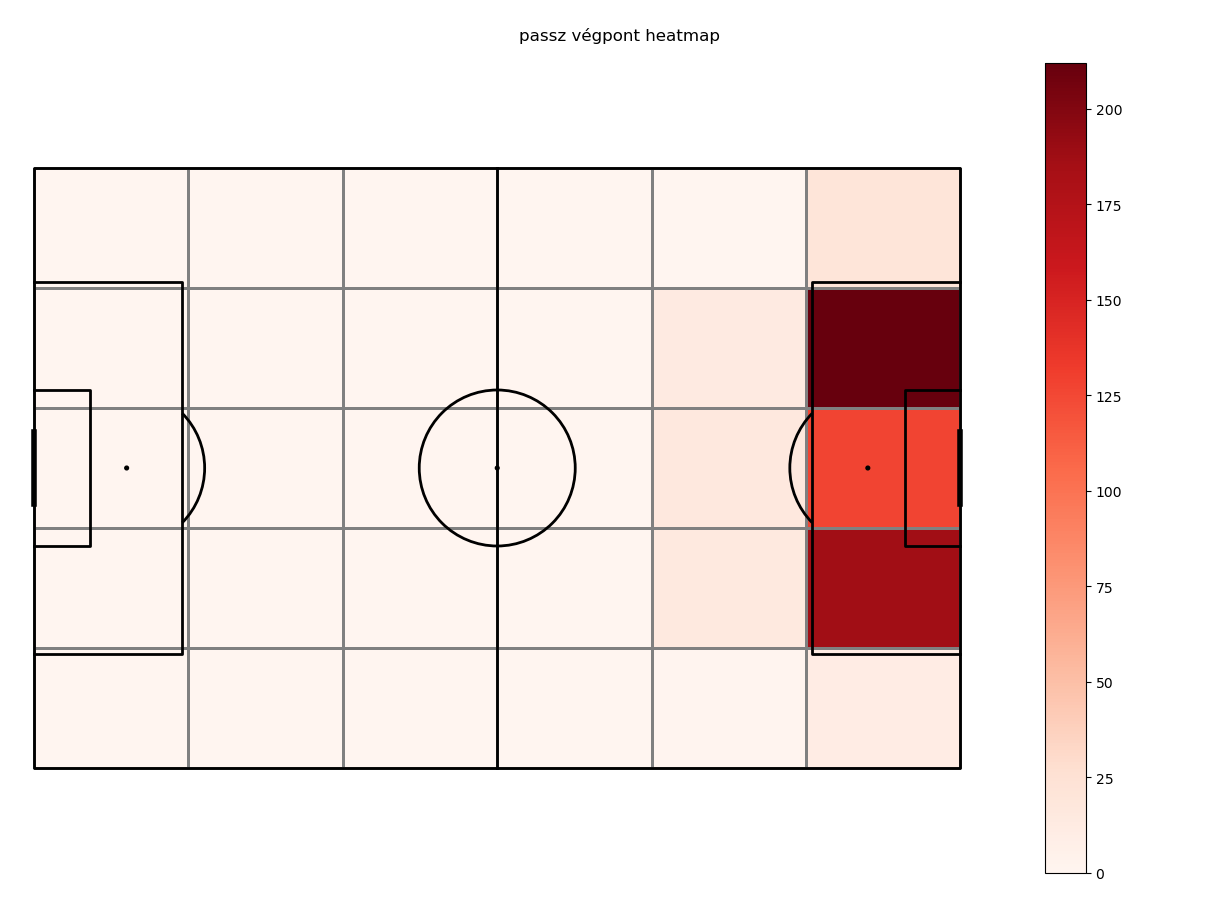

In [44]:
filter_with_label()
plot_passes()

C:\Users\Csaba\AppData\Local\Temp\ipykernel_6688\647811302.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cols = df.corr().nlargest(k, 'xT')['xT'].index


<Axes: >

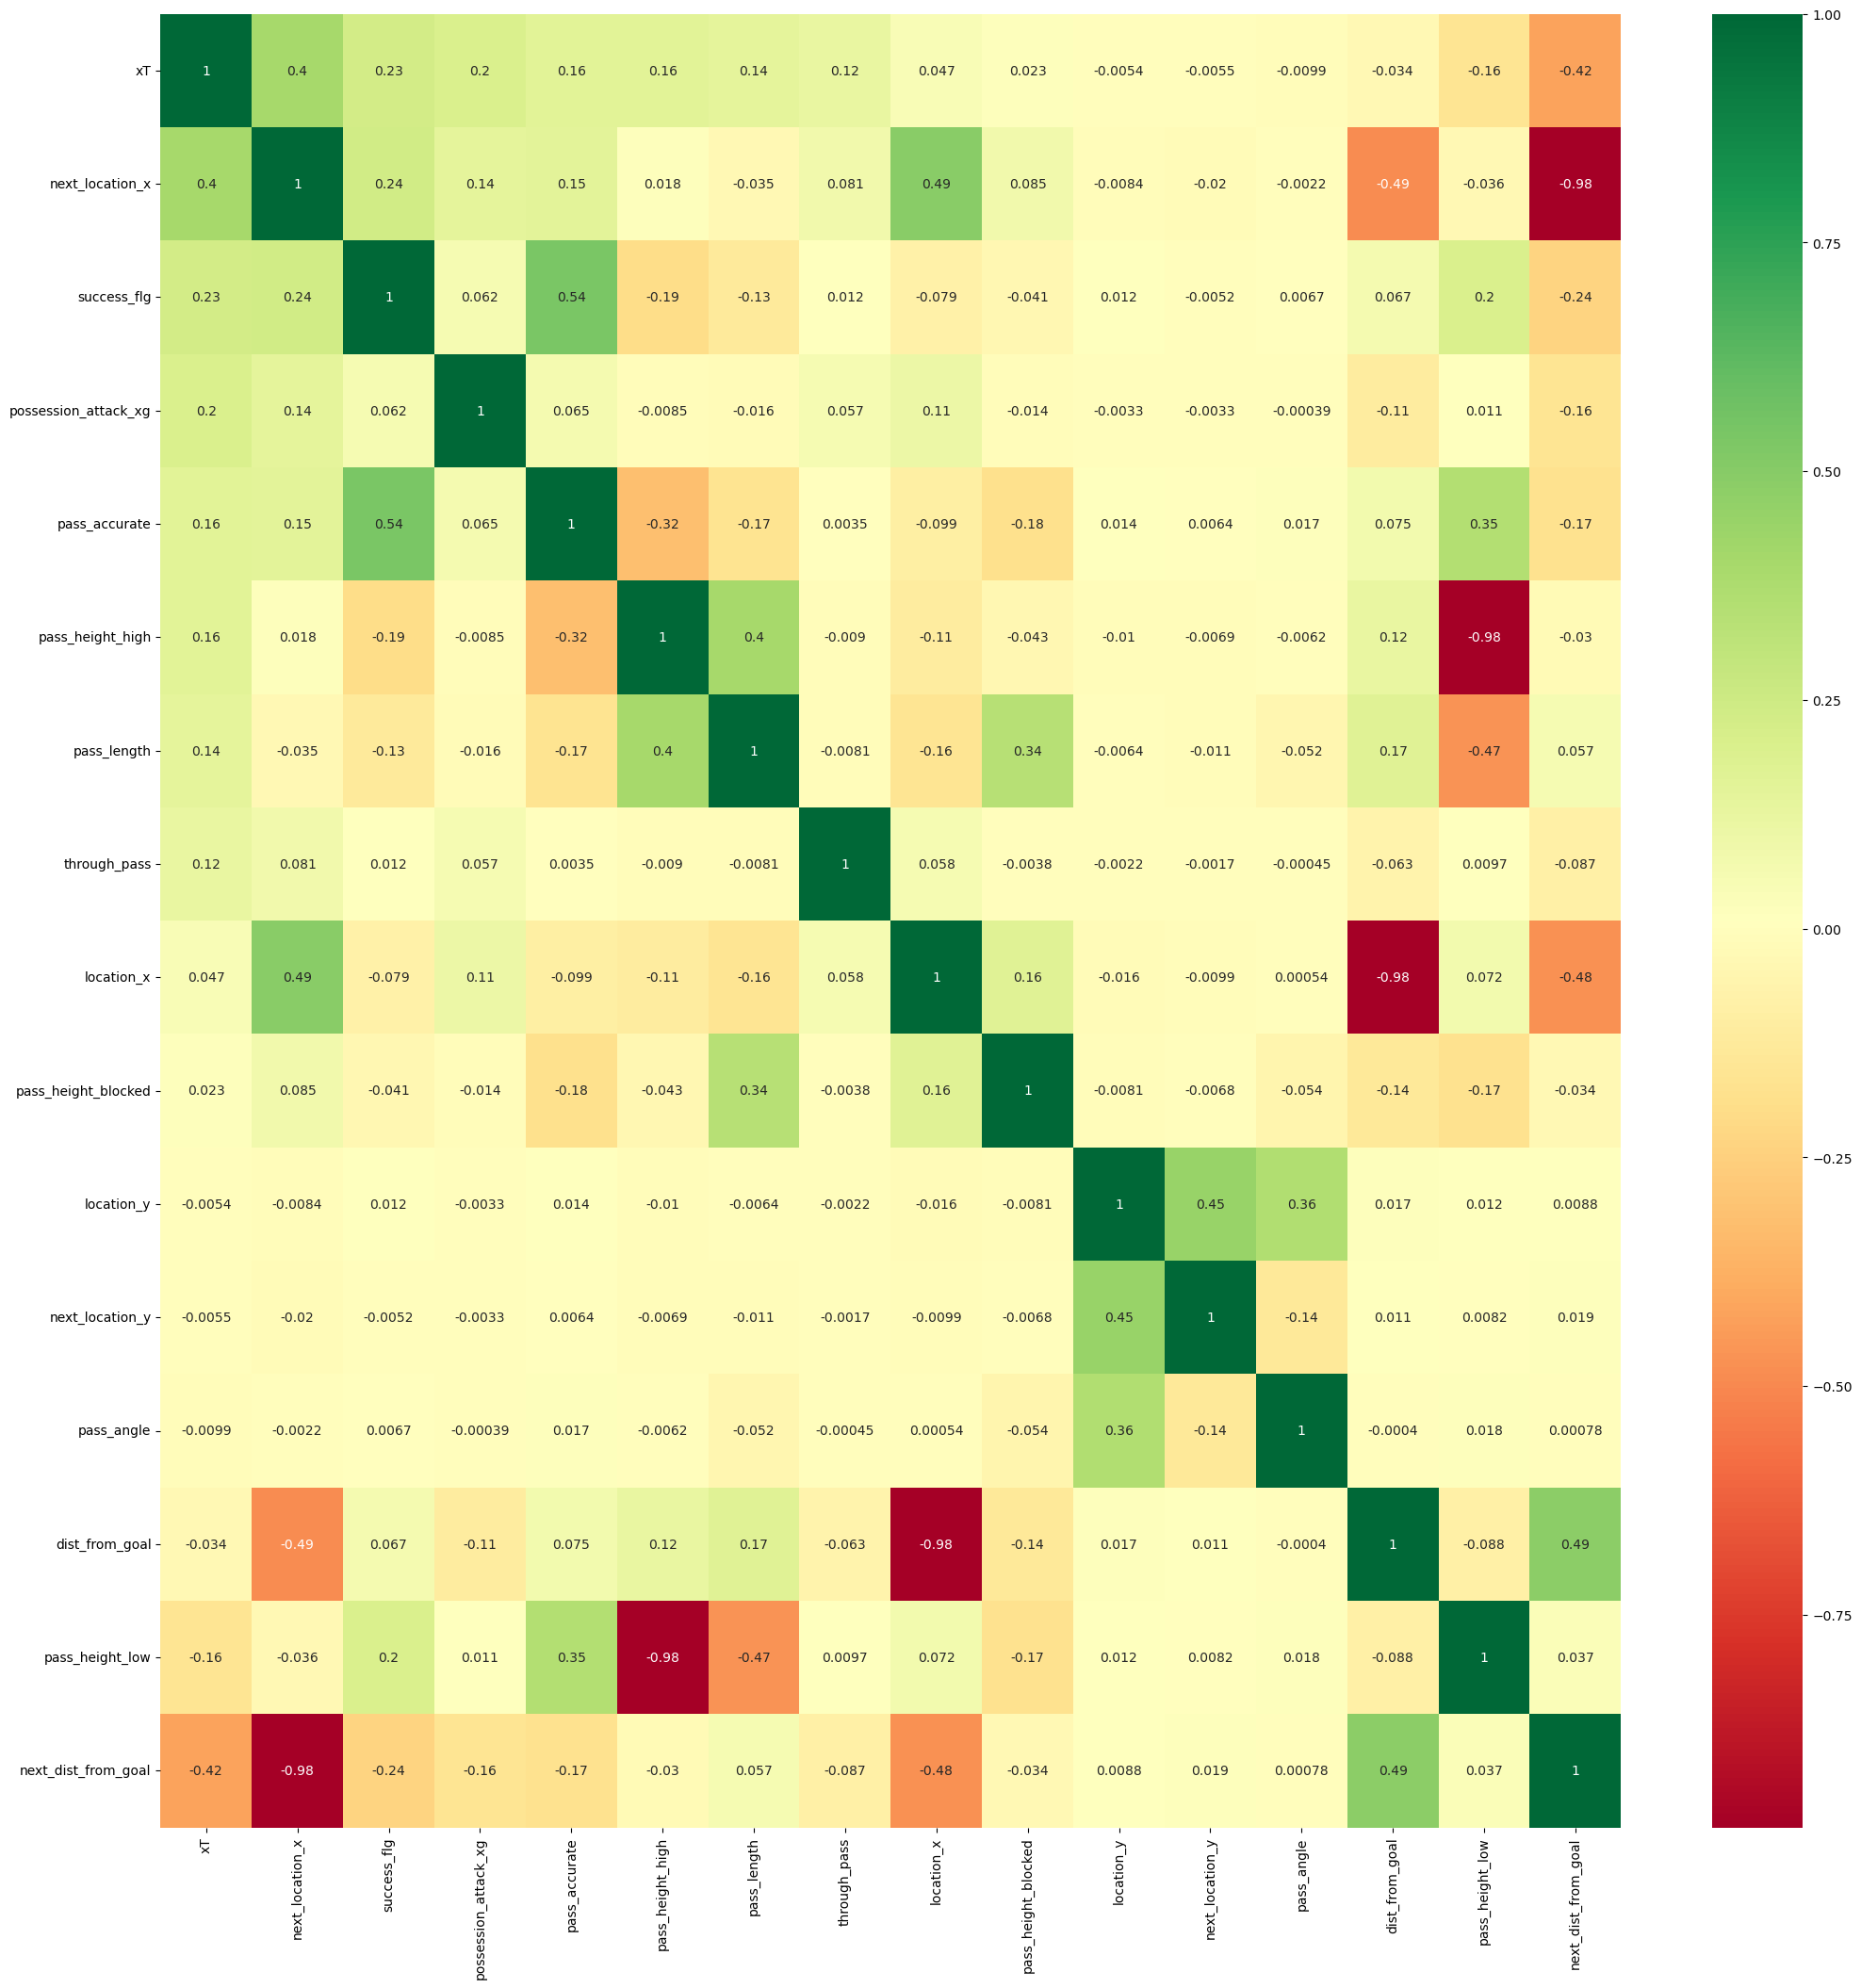

In [45]:
import seaborn as sns

k = 25
cols = df.corr().nlargest(k, 'xT')['xT'].index
cm = df[cols].corr()
plt.figure(figsize=(25,25))
color = plt.get_cmap('RdYlGn')
sns.heatmap(cm, annot=True, cmap = color)

In [50]:
from pandas.api.types import is_string_dtype
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def modeling(i):
    through_passes_col = np.where(((df_copy['next_dist_from_goal'] / df_copy['dist_from_goal'] < basicdf.loc[i]['progress']) & (df_copy['location_x'] > basicdf.loc[i]['front'])), True, False)
    df_copy['through_pass'] = through_passes_col
    index = df_copy[df_copy['through_pass']==False].index
    df_copy.drop(index, inplace=True)
    df_copy.drop(labels=['type_primary', 'type_secondary', 'through_pass', 'next_location_x', 'next_location_y', 'dist_from_goal', 'pass_height_low'], axis=1, inplace=True)
    for c in df_copy:
        if is_string_dtype(df_copy[c]):
            df_copy.drop(labels=c, axis=1, inplace=True)
    
    x = df_copy.values #numpy 2d array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_norm = pd.DataFrame(x_scaled)
    df_norm = df_norm.set_axis(df_copy.columns, axis='columns', copy=False)
    X = df_norm.drop('xT', axis=1)
    Y = df_norm['xT']

    x_train, x_test, y_train, y_test = train_test_split(X ,Y, test_size = 0.2, random_state=42)

    regLin = linear_model.LinearRegression()

    #Training
    regLin.fit(x_train, y_train)
    Training_score_r2_score = regLin.score(x_train, y_train)

    # Predict
    y_pred_lin = regLin.predict(x_test)
    # predicting the accuracy score
    r2score = r2_score(y_test,y_pred_lin)

    mean_abs_error = mean_absolute_error(y_test,y_pred_lin)
    mean_sqrd_error = mean_squared_error(y_test,y_pred_lin)
    root_mean_sqrd_error = mean_squared_error(y_test,y_pred_lin, squared=False)
    metrics = {
        'Training_score_r2_score' : Training_score_r2_score,
        'r2score' : r2score,
        'mean_abs_error' : mean_abs_error,
        'mean_sqrd_error' : mean_sqrd_error,
        'root_mean_sqrd_error' : root_mean_sqrd_error
    }
    return metrics

In [51]:
basicdf['Training_score_r2_score'] = 0
basicdf['mean_abs_error'] = 0
basicdf['mean_sqrd_error'] = 0
basicdf['root_mean_sqrd_error'] = 0
basicdf['r2score'] = 0
for i in range(len(basicdf)):
    df_copy = df.copy()
    metrics = modeling(i)
    basicdf.loc[i, 'Training_score_r2_score'] = metrics['Training_score_r2_score']
    basicdf.loc[i, 'r2score'] = metrics['r2score']
    basicdf.loc[i, 'mean_abs_error'] = metrics['mean_abs_error']
    basicdf.loc[i, 'mean_sqrd_error'] = metrics['mean_sqrd_error']
    basicdf.loc[i, 'root_mean_sqrd_error'] = metrics['root_mean_sqrd_error']
basicdf

,Elől lévő %-os részarány,%-os közelítés,Kiugratások száma,front,progress,Kiugratások aránya,Training_score_r2_score,mean_abs_error,mean_sqrd_error,root_mean_sqrd_error,r2score
0,100.000000,75.0,1016,0,0.25,0.333527,0.752750,0.106943,0.019009,0.137874,0.764743
1,85.714286,75.0,742,15,0.25,0.243580,0.562874,0.126014,0.028339,0.168343,0.541405
2,71.428571,75.0,681,30,0.25,0.223555,0.417796,0.136013,0.035989,0.189709,0.306064
3,57.142857,75.0,638,45,0.25,0.209439,0.310034,0.123448,0.025085,0.158382,0.267306
4,42.857143,75.0,592,60,0.25,0.194339,0.294279,0.137438,0.038882,0.197185,0.113309
5,28.571429,75.0,502,75,0.25,0.164794,0.202918,0.149244,0.039191,0.197968,0.191725
6,100.000000,65.0,4052,0,0.35,1.330169,0.730984,0.089153,0.016796,0.129599,0.709050
7,85.714286,65.0,2961,15,0.35,0.972021,0.643824,0.095641,0.017370,0.131797,0.636309
8,71.428571,65.0,2461,30,0.35,0.807884,0.494710,0.101540,0.018699,0.136743,0.520206
9,57.142857,65.0,2230,45,0.35,0.732052,0.445938,0.098502,0.017817,0.133482,0.432156
